Let's take the straight-track model we have and try to scale it up to more tracks.

Author: Dustin Anderson

In [1]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences


# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

# Scale track slopes up so that slopes and intercepts receive equal weights in the loss function.
slope_scale = det_width/2

# Number of tracks in each event follows Poisson distribution
mean_tracks = 12
max_tracks = 18

In [22]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = zip(bs, ms)
        for i, (b, m) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 2))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

[[  1.19298829  18.11259705]
 [  2.3601626   17.20084731]
 [  2.69613828   5.50784349]
 [  5.26714305  -0.21122638]
 [ 10.56349652   0.7542083 ]
 [ 10.59674501  10.99764945]
 [ 10.82180705   7.17989868]
 [ 16.14775816  10.20506455]
 [ 25.57873616 -10.48603508]
 [ 26.05208837 -11.16164682]
 [ 35.58380225 -16.44121814]
 [ 42.31527433  -1.78780778]
 [ 44.72239959 -21.07703052]
 [ 48.96769475  -3.59440992]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]]


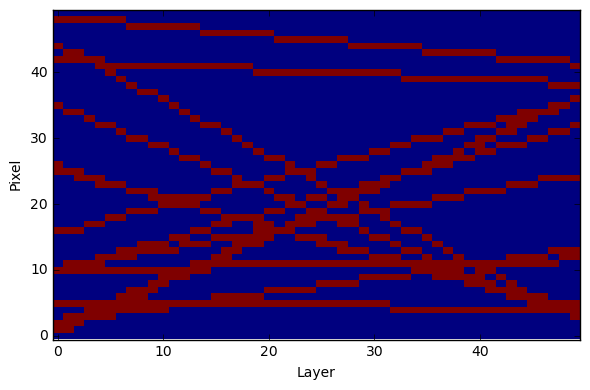

In [4]:
# Test the multi-track generator
tracks, targets = gen_multi_tracks().next()
draw_event(tracks[0,0])
print targets[0]

In [5]:
# Generate a fixed dataset of multi-track events
epoch_size = 512000
gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)

train_events = np.zeros((epoch_size, 1, det_depth, det_width))
train_targets = -99 * np.ones((epoch_size, max_tracks, 2))
train_weights = np.zeros((epoch_size, max_tracks))
for n in range(epoch_size):
    num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
    tracks,targets = gen_single.next()
    train_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))

[[  3.765671    -1.44868038]
 [  4.45829548  16.41234339]
 [ 15.99703026  -1.83661735]
 [ 16.1278983   -3.78112606]
 [ 16.59889557  16.66804107]
 [ 17.64203629   1.06636514]
 [ 27.80780103   3.8795942 ]
 [ 33.81939859  -3.12788736]
 [ 34.94488646   3.93169898]
 [ 35.97922353 -14.93170232]
 [ 39.0979127   -9.91502834]
 [ 40.6521865   -5.99686289]
 [ 47.62992709 -19.86507298]
 [-99.         -99.        ]
 [-99.         -99.        ]
 [-99.         -99.        ]
 [-99.         -99.        ]
 [-99.         -99.        ]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]


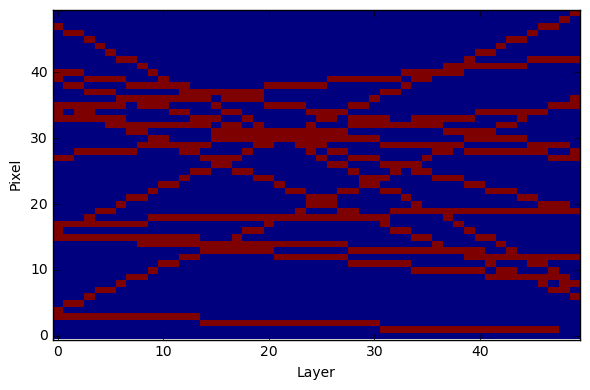

In [7]:
# Check the training data
test_index = np.random.randint(epoch_size)
draw_event(train_events[test_index,0])
print train_targets[test_index]
print train_weights[test_index]

## Model 6: increase layer sizes and number of filters in Model 4

In [8]:
# Model
def build_model_6():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [9]:
# Train the model
model_6 = build_model_6()
train_generator = gen_n_tracks()
%time model_6.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
512000/512000 [==============================] - 338s - loss: 19.8891   
Epoch 2/10
512000/512000 [==============================] - 317s - loss: 6.8818   
Epoch 3/10
512000/512000 [==============================] - 321s - loss: 5.5195   
Epoch 4/10
512000/512000 [==============================] - 341s - loss: 4.9402   
Epoch 5/10
512000/512000 [==============================] - 335s - loss: 4.5699   
Epoch 6/10
512000/512000 [==============================] - 334s - loss: 4.3280   
Epoch 7/10
512000/512000 [==============================] - 323s - loss: 4.1130   
Epoch 8/10
512000/512000 [==============================] - 316s - loss: 3.9892   
Epoch 9/10
512000/512000 [==============================] - 341s - loss: 3.8643   
Epoch 10/10
512000/512000 [==============================] - 337s - loss: 3.7607   
CPU times: user 52min 58s, sys: 17min 59s, total: 1h 10min 57s
Wall time: 55min 18s


[[  1.94781199   3.80585718]
 [  4.71306891  20.58831465]
 [ 11.83054202  12.69195794]
 [ 12.07929121  14.84147016]
 [ 12.53811922   6.37858151]
 [ 17.42640176  10.97652907]
 [ 21.16502577   1.58682612]
 [ 25.8613612   10.79051977]
 [ 34.37589154  -0.65676036]
 [ 39.68027949  -9.11533586]
 [ 46.86963099  -4.40230778]
 [ 47.48617004 -12.87148532]]
[[  1.92375851   4.6093564 ]
 [  4.59947634  20.962183  ]
 [ 11.88545704  14.57069111]
 [ 11.87455273  13.03137493]
 [ 12.50411892   8.78361893]
 [ 17.68852425  11.6174612 ]
 [ 21.35666084  -0.07595556]
 [ 25.32382965  11.30923462]
 [ 34.61265945  -1.02176309]
 [ 39.19515228  -9.05167103]
 [ 46.43860626  -3.99922514]
 [ 47.31015778 -13.88013172]]


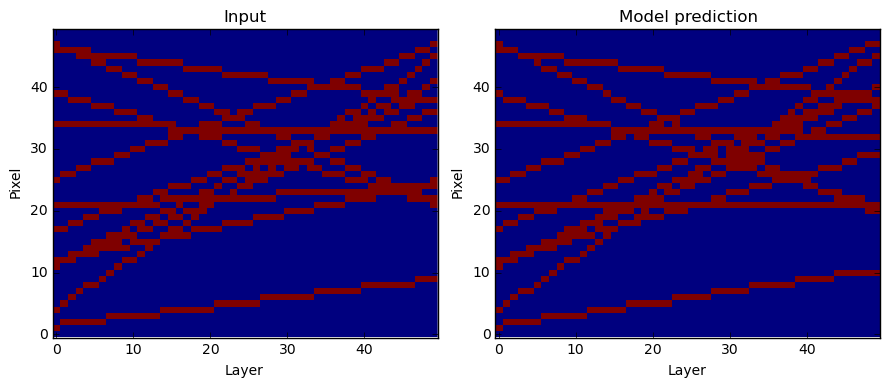

In [15]:
# Visualize prediction
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_6.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

It's not perfect, but the performance is reasonable.  Let's try even more tracks.

In [20]:
mean_tracks = 18

(Re-activate cells 3 and 7 above)

In [23]:
# Train the model
model_6 = build_model_6()
train_generator = gen_n_tracks()
%time model_6.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
512000/512000 [==============================] - 424s - loss: 23.3685   
Epoch 2/10
512000/512000 [==============================] - 436s - loss: 11.7664   
Epoch 3/10
512000/512000 [==============================] - 420s - loss: 9.8878   
Epoch 4/10
512000/512000 [==============================] - 441s - loss: 9.0104   
Epoch 5/10
512000/512000 [==============================] - 430s - loss: 8.4759   
Epoch 6/10
512000/512000 [==============================] - 439s - loss: 8.0947   
Epoch 7/10
512000/512000 [==============================] - 440s - loss: 7.7867   
Epoch 8/10
512000/512000 [==============================] - 441s - loss: 7.5530   
Epoch 9/10
512000/512000 [==============================] - 433s - loss: 7.3537   
Epoch 10/10
512000/512000 [==============================] - 416s - loss: 7.1982   
CPU times: user 1h 10min 26s, sys: 19min 59s, total: 1h 30min 26s
Wall time: 1h 12min 14s


[[  5.91554824e-02   2.27670741e+01]
 [  2.77368758e+00   1.04087838e+01]
 [  1.21479186e+01   1.71258371e+01]
 [  2.14830810e+01   1.91520851e-01]
 [  2.87712196e+01   2.85833209e+00]
 [  2.94536279e+01  -4.95519898e+00]
 [  3.10319452e+01  -4.06177926e+00]
 [  3.40618312e+01   5.92084304e+00]
 [  3.71339508e+01   6.34572128e+00]
 [  3.85828940e+01  -1.39330269e+01]
 [  3.91845974e+01   4.81825161e+00]
 [  3.92021768e+01  -8.42763460e+00]
 [  3.97529443e+01   4.18124286e-01]
 [  3.97704280e+01  -1.18499144e+01]
 [  4.18890798e+01  -3.59467924e-02]
 [  4.49734965e+01  -1.80901614e+00]
 [  4.67677433e+01  -9.80069847e+00]
 [  4.69900477e+01  -2.08269410e+01]]
[[  1.016119    23.93530655]
 [  2.68757915   7.7242403 ]
 [ 12.30080032  17.48934364]
 [ 21.02180862   0.50825197]
 [ 27.84785461   0.26016891]
 [ 29.27734566  -0.2233526 ]
 [ 31.32230568  -7.26005125]
 [ 33.03419495   6.19293118]
 [ 36.99900055   2.55709577]
 [ 37.87192535  -1.84433782]
 [ 38.41908264  -3.06833076]
 [ 38.90982819

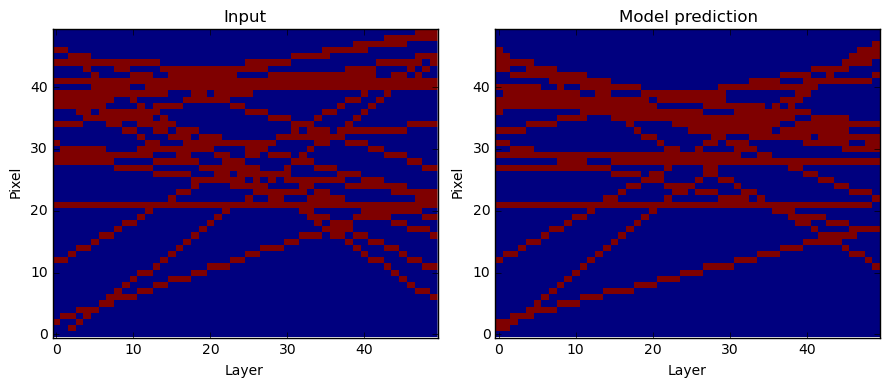

In [29]:
# Visualize prediction
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_6.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

Things have broken down by this point.  The amount of overlap between tracks makes it almost impossible to disentangle them, even for a human.  I think the granularity would need to be increased for tests with this many tracks to make sense.

In [26]:
#Check size of model on disk
import os
model_6.save("model_6.hdf5")
os.path.getsize("model_6.hdf5")

111596568